In [1]:
import numpy as np
import numpy.random as nrnd
import scipy.integrate as sint
import scipy.interpolate as si
from scipy.interpolate import griddata

import sys

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as patches
import matplotlib.colors as colors
import matplotlib.cm as cmx

import cosmicSpec
import protostarCR

label_size=16
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size
nrnd.seed()

In [2]:
#Some parameters...
RSUN = 6.957E10
LSUN = 3.848E33
ALPHA =  0.39704170
BETA  =  8.52762600
GAMMA =  0.00025546
DELTA =  5.43288900
EPSILON = 5.56357900
ZETA  =  0.78866060
ETA   =  0.00586685 
THETA =  1.71535900
IOTA  =  6.59778800
KAPPA = 10.08855000
LAMBDA = 1.01249500
MU    =  0.07490166
NU    =  0.01077422
XI    =  3.08223400
UPSILON = 17.84778000
PI    =  0.00022582

mh = 1.67372E-24
me = 9.109383E-28
kb = 1.380648E-16 #erg/K
kb_eV = 8.617330E-5 #eV/K
RSUN = 6.957E10
MSUN = 1.988E33
G = 6.67259E-8
planck_cgs = 6.6260755E-27 #erg s
cl = 2.998E10 #cm/s
gamma_ad = 5./3.
shock_eff = 0
GeVc_to_cgs = 5.3442859E-14

In [3]:
#Some main sequence functions
def lZAMS(m):
    LZAMS = (ALPHA*m**5.5 + BETA*m**11)/(GAMMA + m**3 + DELTA*m**5 + EPSILON*m**7 
             + ZETA*m**8 + ETA*m**9.5)
    return LZAMS
def rZAMS(m):
    RZAMS = (THETA*m**2.5 + IOTA*m**6.5 + KAPPA*m**11 + LAMBDA*m**19 + 
        MU*m**19.5)/(NU + XI*m**2 + UPSILON*m**8.5 + m**18.5 + PI*m**19.5)
    return RZAMS

In [4]:
#Load up some parameters for a turbulent core model, and
#a radius model for the protostar mass and final mass
deltan1 = 1.
#For TC
j = 0.5
jf = 0.75
Sigma = 1.0 #0.06
m0 = 3.6E-5*Sigma**(0.75)
######
ml = 0.033
mmax = 100.
r = 2.5 #in Solar units
facc = 0.75 #For feedback
L1 = 31.3*facc*(m0/1.0E-6)
#Read in the r(m, mf)
dat = np.loadtxt("TC_m_mf_r.txt")
ms = dat[:,0]; mfs = dat[:,1]; rs = dat[:,2] # 2.5*np.ones(len(dat[:,0])) #
mp = ms.reshape((69,5001)); mfp = mfs.reshape((69, 5001)); rp = rs.reshape((69, 5001))
for i in range(69):
    ir = np.where(mp[i] >= mfp[i])[0][0]
    rval = rp[i][ir]
    rp[i][np.where(mp[i] >= mfp[i])] = rval
ms = mp.flatten(); mfs = mfp.flatten(); rs = rp.flatten()
dum0, dum1 = np.mgrid[np.amin(ms):np.amax(ms):250j, np.amin(mfs):np.amax(mfs):250j]
grid_r = griddata((ms, mfs), rs, (dum0, dum1), method='nearest')
rspl = si.RectBivariateSpline(dum0[:,0], dum1[0,:], grid_r, s = 2, kx=1, ky=1)
#delete variables not used to clear memory
del dat; del ms; del mfs; del rs; del dum0; del dum1; del grid_r;  del mp;
del mfp; del rp;

def acc(m, mf):
    return m0*(m/mf)**j*mf**jf*(1. - deltan1*(m/mf)**(1.-j))**(0.5)

In [5]:
CRSPEC = cosmicSpec.CRSpectrum()
protoCR = protostarCR.ProtostarCR()
CRSPEC.add_range("LE_loss_p.txt")
protoCR.addLossFunction("LE_loss_p.txt")

B0 = 1E1
mu = 0.6

Nene = 400
earr = np.logspace(2, np.log10(1E10), Nene)
#Cross section WITHOUT relativistic correction
a0 = 5.29177211E-9 #cm
I = 13.598
memp = 5.44617E-4; A = 0.71; B = 1.63; C = 0.51; D = 1.24;
xarr = memp*(earr/13.598)
sigmal = 4.*np.pi*a0**2*C*xarr**D
sigmah = 4.*np.pi*a0**2*(A*np.log(1+xarr) + B)*(1./xarr)
sigmap = 1./((1./sigmal) + (1./sigmah))

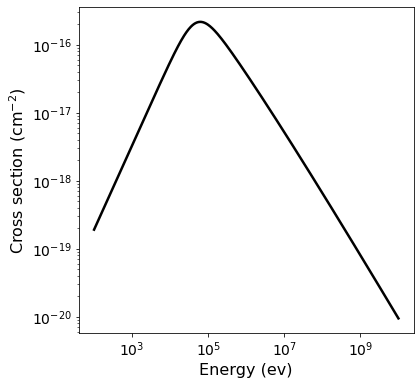

In [6]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.loglog(earr, sigmap, 'k-', lw=2.5)
ax.set_xlabel("Energy (ev)", fontsize=16)
ax.set_ylabel("Cross section (cm$^{-2}$)", fontsize=16)
ax.tick_params(which='both', axis='both', labelsize=14)
plt.show()

In [9]:
#Just a test here to get a spectrum for a protostar with mass, m, final mass, m_f
#give it a CRSPEC and protoCR classes to do the attenuation and spectrum generation
def get_spec(mi, mf, CRSPEC, protoCR, atten=True, fullOut = False, ruse = None, atrans = 2.0, NCOL=None):
    a2 = 3. # dipole moment, stellar field
    a8 = 7. # octpole moment, stellar field
    a10 = 9. # higher order momentsm, stellar field
    fmacc = 0.1 #accretion column filling fractions
    ri = rspl.ev(mi ,mf) #Get the radius in Rsun
    magdip = B0*(ri*RSUN)**3 #Magnetic dipole
    mdot = max(acc(mi, mf), 1E-20)*6.305286E25 #accretion rate in g/s
    rmi = 0.7*(magdip**4/(4*G*mi*MSUN*mdot**2))**(1./7.) #magnetosonic radius
    #Get the free-fall veloctiy, temperature and density of the shock
    vffi = ((2.*G*mi*MSUN)/(ri*RSUN))**(0.5)
    tsi = (3./16.)*((mu*mh)/(kb))*vffi**2
    ni = (1./(mu*mh))*mdot*(1./(fmacc*4.*np.pi*(ri*RSUN)**2*vffi))

    #Just a limiting factor
    rmi = max(4.*ri*RSUN, rmi)
    
    #Solve the constraint equations
    eparams = protoCR.calcSpecParams(vffi/1E5, tsi, ni, B0, ri*(0.00465))
    #Get the spectrum
    CRSPEC.gen_spectrum(eparams['pmin'], eparams['pmax'], eparams['q'], eparams['f0'])
    ei, ji = CRSPEC.get_nullSpectrum(retType = 'raw')

    #Attenuate to either the core radius, or some other radius
    if ruse == None:
        rcore = 0.057*(Sigma)**(-0.5)*(mf/30.)**(0.5)*3.086E18
    else:
        rcore = ruse
    if atten == True:
        #eatten, jatten = CRSPEC.attenuate_provided_v2(ei, jatten_1, NCOL)
        #jatten2_f = jatten2 * ((ri*RSUN)/rcore)**atrans
        CRSPEC.attenuate_spec_v2(NCOL)
        CRSPEC.spatial_dilute_spec(ri*RSUN, rcore, p = atrans)
        espace, je = CRSPEC.get_dilutedSpectrum(retType='raw')
        #espace = eatten2
        #je = jatten2_f
    else:
        espace, je = CRSPEC.get_nullSpectrum(retType = 'raw')
    if fullOut:
        return espace, je, eparams
    else:
        return espace, je, eparams['emax']

Sigma = 1.000000e+00	NCOL = 2.603269e+23

Generating 1D spectra plots
Setting mass to:  0.5


/Users/brandt/projects/ProtostarCRs/protostarCR.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  return 1./np.sqrt(1. - beta**2)
/Users/brandt/projects/ProtostarCRs/protostarCR.py:99: RuntimeWarning: invalid value encountered in double_scalars
  return gamma(beta)*beta**2 - fac


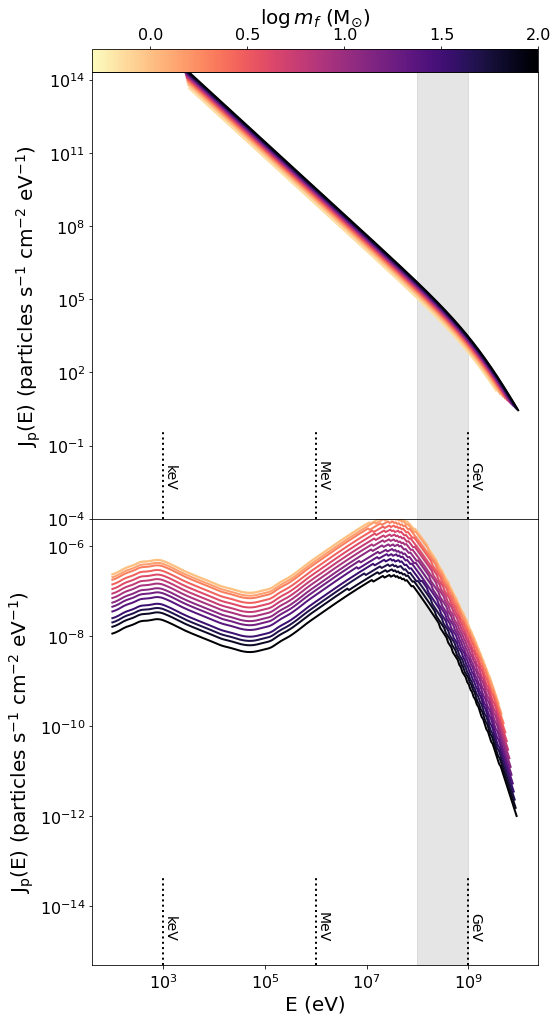

In [11]:
Sigma = 1.0
m0 = 3.6E-5*Sigma**(0.75)
#NCOL = 1.22*(Sigma/(1.4*mh))
NCOL = 1.22*(Sigma/(2.8*mh))
print("Sigma = %e\tNCOL = %e\n"%(Sigma, NCOL))

print("Generating 1D spectra plots")
flux_atten_mat = []
flux_unatten_mat = []
ei_atten_mat = []
ei_unatten_mat = []
slopes_a = []
offsets_a = []
slopes_u1 = []
offsets_u1 = []
slopes_u2 = []
offsets_u2 = []
MISET = 0.5
#MISET = 0.3
print("Setting mass to: ", MISET)
mfplots = np.logspace(np.log10(MISET), np.log10(mmax), 16)
magma = plt.get_cmap('magma_r')
cNorm = colors.Normalize(vmin=np.log10(mfplots[0]), vmax=np.log10(mfplots[-1]))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=magma)
scalarMap._A = []

XION = np.logspace(np.log10(0.1E9), 9, 12)
ylu = np.ones(12)*1E-5; yuu = np.ones(12)*1E15
yla = np.ones(12)*1E-16; yua = np.ones(12)*(1E-5)
E1 = np.logspace(5,8,12)
E2 = np.logspace(np.log10(5E8),10.2,12)
E3 = np.logspace(8.5,9.8,12)
color_atten = []
color_unatten = []
for attenP in [True, False]:
    for mfip in mfplots:
        color = scalarMap.to_rgba(np.log10(mfip))
        if mfip > MISET:
            ei, ji, emax = get_spec(MISET, mfip, CRSPEC, protoCR, atten=attenP, NCOL=NCOL)
            if attenP:
                flux_atten_mat.append(ji)
                ei_atten_mat.append(ei)
                color_atten.append(color)
            else:
                flux_unatten_mat.append(ji)
                ei_unatten_mat.append(ei)
                color_unatten.append(color)

fig, (axU, axA) = plt.subplots(2, sharex=True,  figsize=(8,16))
fig.subplots_adjust(wspace=0);fig.subplots_adjust(hspace=0);
axA.axvline(x=1E3, color='k', linestyle=':', linewidth=2, ymax=0.2); axA.axvline(x=1E6, color='k', linestyle=':', linewidth=2, ymax=0.2); axA.axvline(x=1E9, color='k', linestyle=':', linewidth=2, ymax=0.2);
axA.annotate("keV", xy=(1E3, 2E-15), xytext=(1E3, 2E-15), rotation=-90, fontsize=14); axA.annotate("MeV", xy=(1E6, 2E-15), xytext=(1E6, 2E-15), rotation=-90, fontsize=14);
axA.annotate("GeV", xy=(1E9, 2E-15), xytext=(1E9, 2E-15), rotation=-90, fontsize=14)
axU.axvline(x=1E3, color='k', linestyle=':', linewidth=2, ymax=0.2); axU.axvline(x=1E6, color='k', linestyle=':', linewidth=2, ymax=0.2); axU.axvline(x=1E9, color='k', linestyle=':', linewidth=2, ymax=0.2);
axU.annotate("keV", xy=(1E3, 2E-3), xytext=(1E3, 2E-3), rotation=-90, fontsize=14); axU.annotate("MeV", xy=(1E6, 2E-3), xytext=(1E6, 2E-3), rotation=-90, fontsize=14);
axU.annotate("GeV", xy=(1E9, 2E-3), xytext=(1E9, 2E-3), rotation=-90, fontsize=14)


axU.fill_between(XION, ylu, yuu, color='gray', alpha=0.2)
axA.fill_between(XION, yla, yua, color='gray', alpha=0.2)

ii = 0
for mfp in mfplots[1:]:
    if mfp > MISET:
        color = scalarMap.to_rgba(np.log10(mfp))
        axA.loglog(ei_atten_mat[ii], flux_atten_mat[ii], color=color, linewidth=2)
        axU.loglog(ei_unatten_mat[ii], flux_unatten_mat[ii], color=color, linewidth=2)
        ii += 1

axA.set_xlabel("E (eV)", fontsize=20)
axU.set_ylabel(r"J$_{\rm p}$(E) (particles s$^{-1}$ cm$^{-2}$ eV$^{-1}$)", fontsize=20)
axA.set_ylabel(r"J$_{\rm p}$(E) (particles s$^{-1}$ cm$^{-2}$ eV$^{-1}$)", fontsize=20)
axU.set_ylim(1E-4, 2E14); axA.set_ylim(5E-16, 4E-6)

fig.subplots_adjust(top=0.90, hspace=0.00)
cax2 = fig.add_axes([0.125, 0.90, 0.775, 0.02])
c1 = fig.colorbar(scalarMap, cax = cax2, orientation='horizontal')
c1.ax.xaxis.set_ticks_position('top')
c1.ax.xaxis.set_label_position('top')
c1.set_label(r"$\log \, m_f$ (M$_{\odot}$)", fontsize=20)#, labelpad=-75)
#fig.savefig("Half_solar_spectra_vert.png", bbox_inches='tight')
plt.show()

Generating 2D plots


/Users/brandt/opt/anaconda2/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log10
/Users/brandt/opt/anaconda2/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:58: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
/Users/brandt/opt/anaconda2/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in log10
/Users/brandt/opt/anaconda2/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:69: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gour

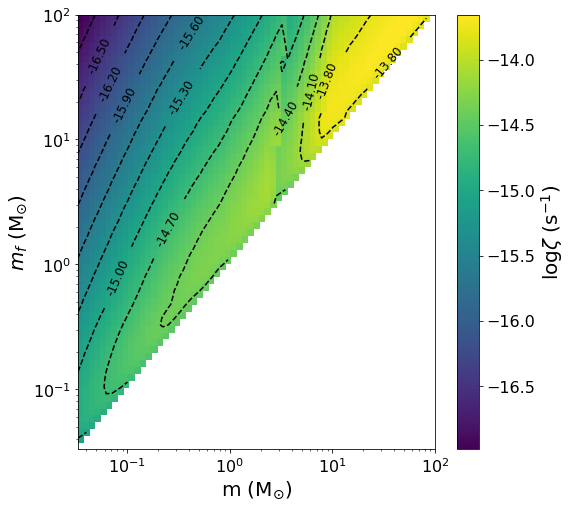

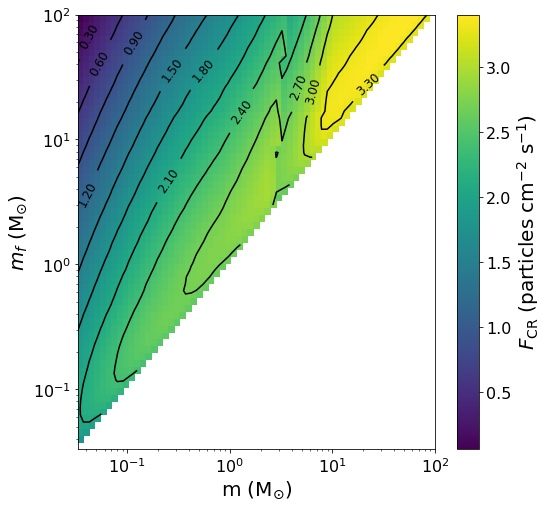

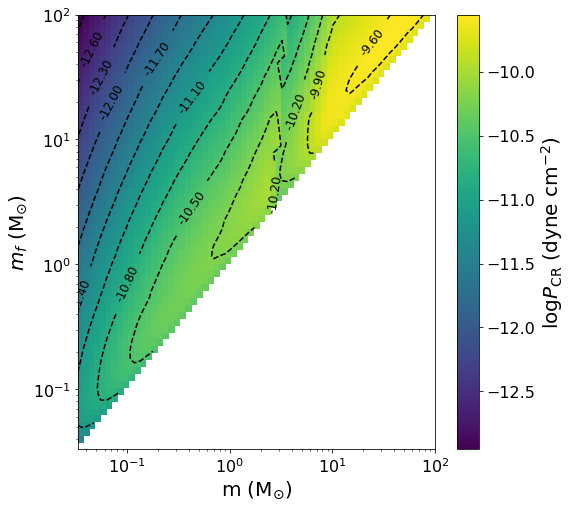

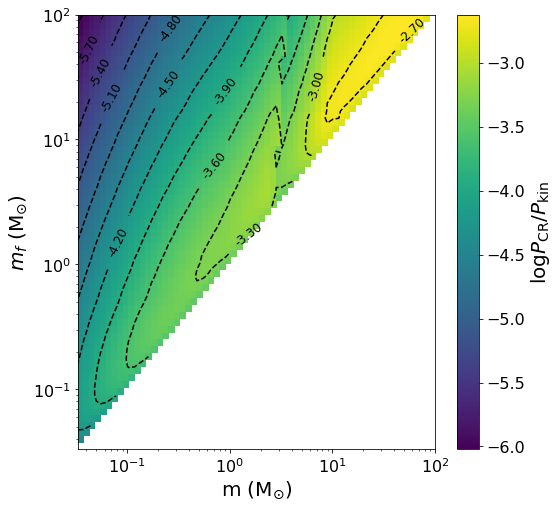

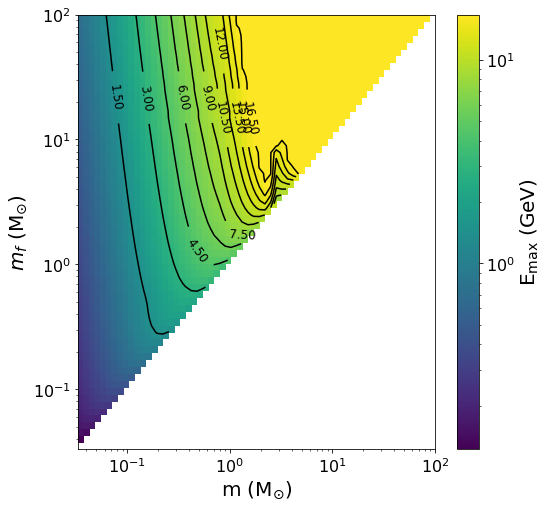

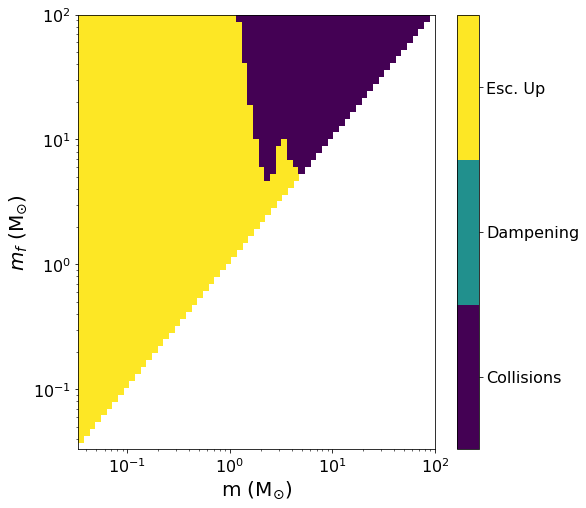

In [16]:
print("Generating 2D plots")
massres = 64
marr = np.logspace(np.log10(ml), np.log10(mmax), massres)
mfarr = np.logspace(np.log10(ml), np.log10(mmax), massres)
mgrid, mfgrid = np.meshgrid(marr, mfarr)

def pfuncE(E):
    mpc2 = 0.938 #GeV
    return np.sqrt((E + mpc2)**2 - mpc2**2)

zeta_mat = np.zeros((massres, massres), 'float64')
FLUX_mat = np.zeros((massres, massres), 'float64')
PCR_mat = np.zeros((massres, massres), 'float64')
PRA_mat = np.zeros((massres, massres), 'float64')
EMAX_mat = np.zeros((massres, massres), 'float64')
LOSS_type = np.zeros((massres, massres), 'float64')
LOSS_type.astype(int)
attenF = True
for jj in range(massres):
    for ii in range(massres):
        if marr[ii] < mfarr[jj]:
            ei, ji, eparams = get_spec(marr[ii], mfarr[jj], CRSPEC, protoCR, atten=attenF, NCOL=NCOL, fullOut=True)
            if len(ji) == 0:
                print("Flooring values for m = %.3f, mf = %.3f"%(marr[ii], mfarr[jj]))
                PCR = 1E-18; CRIRi = 1E-20; CRIRe = 1E-21; FLUXi = 1E-4
            else:
                ei = np.ma.masked_where(ji == 0., ei).compressed()
                ji = np.ma.masked_where(ji == 0., ji).compressed()
                ei = ei[:-1]; ji = ji[:-1]
                pi = pfuncE(ei/1E9)*(5.3442859E-14) #turn p from eV -> eV/c -> cgs
                PCR = (4.*np.pi/3.)*sint.trapz(pi*ji, x = ei) #Double check units here
                ji_interp = si.interp1d(np.log10(ei), np.log10(ji), bounds_error=False,fill_value=-1E6)
                jnew = 10**ji_interp(np.log10(earr))
                integrand = jnew*sigmap
                CRIRi = 2.*np.pi*sint.trapz(integrand, x = earr)
                FLUXi = sint.trapz(ji, x = ei)
                if np.isnan(CRIRi):
                    print("NAN CRIR: ")
                    print("m, mf = ", marr[ii], mfarr[jj])
                    print("min/max ji = ", min(ji), max(ji))
                    print("Emax/Losstyle = ", eparams['emax'], eparams['losstype'])
            if attenF:
                kinP = 2.0*0.88*G*Sigma**2 #From McKee & Tan 2003, eq 13
            else:
                sVals = get_shock_vals(marr[ii], mfarr[jj])
                kinP = (sVals['n']*(mh)*0.6)*sVals['vff']**2
            zeta_mat[jj,ii] = CRIRi
            FLUX_mat[jj,ii] = FLUXi
            PCR_mat[jj,ii] = PCR
            PRA_mat[jj,ii] = PCR/kinP
            EMAX_mat[jj,ii] = eparams['emax']
            LOSS_type[jj,ii] = int(eparams['losstype']+1)


lZ = np.ma.masked_where(zeta_mat == 0, np.log10(zeta_mat))
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
p1 = ax.pcolor(marr, mfarr, lZ, cmap=plt.cm.viridis)
con1 = ax.contour(marr, mfarr, lZ, 12, colors='k')
ax.set_xlabel("m (M$_{\odot}$)", fontsize=20); ax.set_ylabel("$m_f$ (M$_{\odot}$)", fontsize=20)
ax.set_xscale('log'); ax.set_yscale('log')
c1 = plt.colorbar(p1)
plt.clabel(con1, fontsize=12, inline=1, inline_spacing=12, fmt="%.2f")
c1.set_label("$\log \zeta$ (s$^{-1}$)", fontsize=20)

lF = np.ma.masked_where(FLUX_mat == 0, np.log10(FLUX_mat))
fig2 = plt.figure(figsize=(8,8))
ax2 = fig2.add_subplot(111)
p2 = ax2.pcolor(marr, mfarr, lF, cmap=plt.cm.viridis)
con2 = ax2.contour(marr, mfarr, lF, 12, colors='k')
ax2.set_xlabel("m (M$_{\odot}$)", fontsize=20); ax2.set_ylabel("$m_f$ (M$_{\odot}$)", fontsize=20)
ax2.set_xscale('log'); ax2.set_yscale('log')
plt.clabel(con2, fontsize=12, inline=1, inline_spacing=12, fmt="%.2f")
c2 = fig2.colorbar(p2)
c2.set_label(r"$F_{\rm CR}$ (particles cm$^{-2}$ s$^{-1}$)", fontsize=20)

lP = np.ma.masked_where(PCR_mat == 0, np.log10(PCR_mat))
fig3 = plt.figure(figsize=(8,8))
ax3 = fig3.add_subplot(111)
p3 = ax3.pcolor(marr, mfarr, lP, cmap=plt.cm.viridis)
con3 = ax3.contour(marr, mfarr, lP, 12, colors='k')
ax3.set_xlabel("m (M$_{\odot}$)", fontsize=20); ax3.set_ylabel("$m_f$ (M$_{\odot}$)", fontsize=20)
ax3.set_xscale('log'); ax3.set_yscale('log')
plt.clabel(con3, fontsize=12, inline=1, inline_spacing=12, fmt="%.2f")
c3 = fig3.colorbar(p3)
c3.set_label(r"$\log P_{\rm CR}$ (dyne cm$^{-2}$)", fontsize=20)

lR = np.ma.masked_where(PRA_mat == 0, np.log10(PRA_mat))
fig4 = plt.figure(figsize=(8,8))
ax4 = fig4.add_subplot(111)
p4 = ax4.pcolor(marr, mfarr, lR, cmap=plt.cm.viridis)
con4 = ax4.contour(marr, mfarr, lR, 12, colors='k')
ax4.set_xlabel("m (M$_{\odot}$)", fontsize=20); ax4.set_ylabel("$m_f$ (M$_{\odot}$)", fontsize=20)
ax4.set_xscale('log'); ax4.set_yscale('log')
plt.clabel(con4, fontsize=12, inline=1, inline_spacing=12, fmt="%.2f")
c4 = fig4.colorbar(p4)
c4.set_label(r"$\log P_{\rm CR}$/$P_{\rm kin}$", fontsize=20)

from matplotlib.colors import LogNorm
lE = np.ma.masked_where(EMAX_mat == 0, EMAX_mat)
fig5 = plt.figure(figsize=(8,8))
ax5 = fig5.add_subplot(111)
p5 = ax5.pcolor(marr, mfarr, lE, norm = LogNorm(), cmap=plt.cm.viridis)
con5 = ax5.contour(marr, mfarr, lE, 12, colors='k')
ax5.set_xlabel("m (M$_{\odot}$)", fontsize=20); ax5.set_ylabel("$m_f$ (M$_{\odot}$)", fontsize=20)
ax5.set_xscale('log'); ax5.set_yscale('log')
plt.clabel(con5, fontsize=12, inline=1, inline_spacing=12, fmt="%.2f")
c5 = fig5.colorbar(p5)
c5.set_label(r"E$_{\rm max}$ (GeV)", fontsize=20)

#2,3,4
import matplotlib.colors as colors
#bounds = np.array([1, 2, 3, 4, 5])
lT = np.ma.masked_where(LOSS_type == 0, LOSS_type)
bounds = np.array([1.5, 2.5, 3.5, 4.5])
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
fig6 = plt.figure(figsize=(8,8))
ax6 = fig6.add_subplot(111)
p6 = ax6.pcolor(marr, mfarr, lT, norm = norm, vmin = 2, vmax = 4, cmap=plt.cm.viridis)
ax6.set_xlabel("m (M$_{\odot}$)", fontsize=20); ax6.set_ylabel("$m_f$ (M$_{\odot}$)", fontsize=20)
ax6.set_xscale('log'); ax6.set_yscale('log')
c6 = fig6.colorbar(p6, ticks=[2,3,4])
c6.ax.set_yticklabels(["Collisions", "Dampening", "Esc. Up"])
plt.show()